In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
from matplotlib import pyplot
from numpy import save
from scipy.linalg import null_space
import matplotlib.ticker as ticker

In [2]:
a = np.loadtxt('BA-100-3-1.txt')
# a = np.loadtxt('colombian.txt')
# a = np.loadtxt('ER-100-6-1.txt')
# a = np.loadtxt('geographical threshold graph with threshold 80.txt')
# a = np.loadtxt('LFR model small mu.txt')
# a = np.loadtxt('powerlaw cluster graph p=0.5.txt')
# a = np.loadtxt('random clustered graph indpendent 1.txt')
# a = np.loadtxt('USAir97-unweighted.txt')


Edges=[]
for i in range(0, len(a)):
    Edges.append((a[i][0],a[i][1]))

G = nx.Graph()
G.add_edges_from(Edges)

In [3]:
# Input the parameter we use in the paper
N = G.number_of_nodes()
rho = 1
mu = 1

In [4]:
# Let Edges be the list of the giant components of G

Edges = list(G.edges())

Total_Edges = []
for i in range(0,2*len(Edges)):
    if i < len(Edges):
        Total_Edges.append(Edges[i])
    else:
        Total_Edges.append((Edges[i - len(Edges)][1], Edges[i - len(Edges)][0]))

In [5]:
# Find the adjacent matrix A
def A(a, b):
    Empty = np.zeros((len(Total_Edges), len(Total_Edges)))
    for i in range(0, len(Total_Edges)):
        for j in range(0, len(Total_Edges)):
            if Total_Edges[i][1] == Total_Edges[j][0]:
                if Total_Edges[i][0] == Total_Edges[j][1]:
                    Empty[i, j] = a
                elif (Total_Edges[i][0], Total_Edges[j][1]) in Total_Edges:
                    Empty[i, j] = b
                else:
                    Empty[i, j] = 1
    return Empty

# find the diagonal matrix D

def D_inverse(a, b):
    D = np.sum(A(a, b), axis = 1)
    D = np.diag(D)
    D_inverse = inv(D)
    return D_inverse

# find transition probability matrix T

def T(a, b):
    T = np.dot(D_inverse(a, b), A(a, b))
    return T

In [6]:
# define M
M = np.zeros((len(Total_Edges), len(Total_Edges)))
for i in range(0, len(Total_Edges)):
    for j in range(0, len(Total_Edges)):
        if Total_Edges[j][1] == Total_Edges[i][1]:
            M[i, j] = 1

In [7]:
def p(a, b):
    p = null_space(np.transpose(T(a, b))-np.identity(len(Total_Edges)))
    arr = []
    for i in range(0,len(Total_Edges)):
        arr.append(p[i][0])
    p = np.array(arr)
    return p/np.sum(p)

In [8]:
# define J_2
# b is the parameter of node2vec
# beta is the infectious rate

def J_2(a, b, D_I, beta):
    Empty = np.zeros((len(Total_Edges), len(Total_Edges)))
    Empty = np.dot(beta*np.diag(p(a, b))*rho*N, M) - (mu + D_I)*np.identity(len(Total_Edges)) + D_I*np.transpose(T(a, b))
    return Empty

In [9]:
def truthfunc(a, b, D_I, beta):
    return np.all(LA.eigvals(J_2(a, b, D_I, beta)).real <= 0)

In [10]:
# a, b are from node2vec; x, y are for bisection method
def bisection(a, b, D_I, x, y): 
  
    if (truthfunc(a, b, D_I, x) == True and truthfunc(a, b, D_I, y) == True) or (truthfunc(a, b, D_I, x) == False and truthfunc(a, b, D_I, y) == False): 
        return 777
   
    z = x
    while ((y - x) >= 10**(-4)): 
  
        # Find middle point 
        z = (x + y)/2
        
        # Decide the side to repeat the steps 
        if (truthfunc(a, b, D_I, z) == True and truthfunc(a, b, D_I, x) == False) or (truthfunc(a, b, D_I, z) == False and truthfunc(a, b, D_I, x) == True):
            y = z 
        else: 
            x = z 
    return z


In [11]:
# two endpoints for bisection method, if D_I=1

x = 0.01
y = 1.0
D_I = 1

mesh = np.linspace(0.01, 5, 50)
mesh1 = np.linspace(0.01, 5, 50)
mesh2 = np.linspace(0.01, 10, 50)

Heat_Matrix1 = np.zeros((len(mesh), len(mesh)))
Heat_Matrix2 = np.zeros((len(mesh1), len(mesh2)))
Heat_Matrix3 = np.zeros((len(mesh1), len(mesh2)))

for i in range(0, len(mesh)):
    for j in range(0, len(mesh)):
        Heat_Matrix1[len(mesh) - j - 1][i]=bisection(mesh[i], mesh[j], D_I, x, y)

for i in range(0, len(mesh1)):
    for j in range(0, len(mesh2)):
        Heat_Matrix2[len(mesh2) - j - 1][i]=bisection(a, mesh1[i], mesh2[j], x, y)

for i in range(0, len(mesh)):
    for j in range(0, len(mesh)):
        Heat_Matrix3[len(mesh) - j - 1][i]=bisection(mesh1[i], b, mesh2[j], x, y)

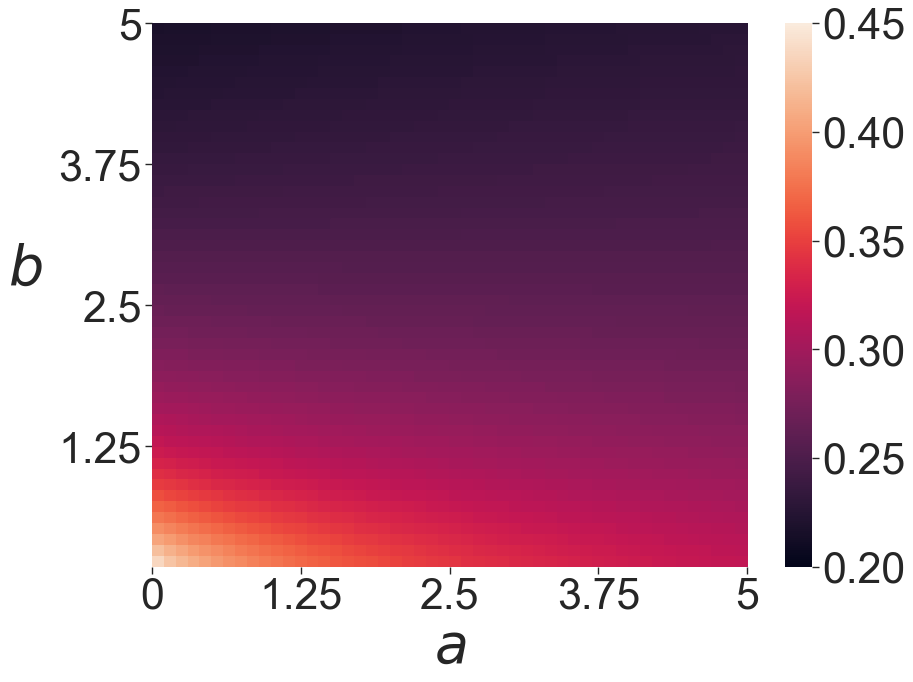

In [12]:
figure(num = None, figsize = (12, 9), dpi = 80, facecolor = 'w', edgecolor = 'k')
sns.set(font_scale = 3.5)

xticks = [-0.5, 0, 1.25, 2.5, 3.75, 5]
yticks = [2.5, 5, 3.75, 2.5, 1.25, 0]

ax = sns.heatmap(Heat_Matrix1, xticklabels = xticks, yticklabels = yticks, vmin = 0.2, vmax = 0.45)
ax.tick_params(left = True, bottom = True)
plt.xlabel("$a$", labelpad = 5, fontsize = 50)
plt.ylabel("$b$", labelpad = 30, fontsize = 50, rotation = 0)
plt.xticks(rotation = 0) 
plt.yticks(rotation = 0)

ax.xaxis.set_major_locator(ticker.MultipleLocator(12.49))
ax.yaxis.set_major_locator(ticker.MultipleLocator(12.97))
plt.show()

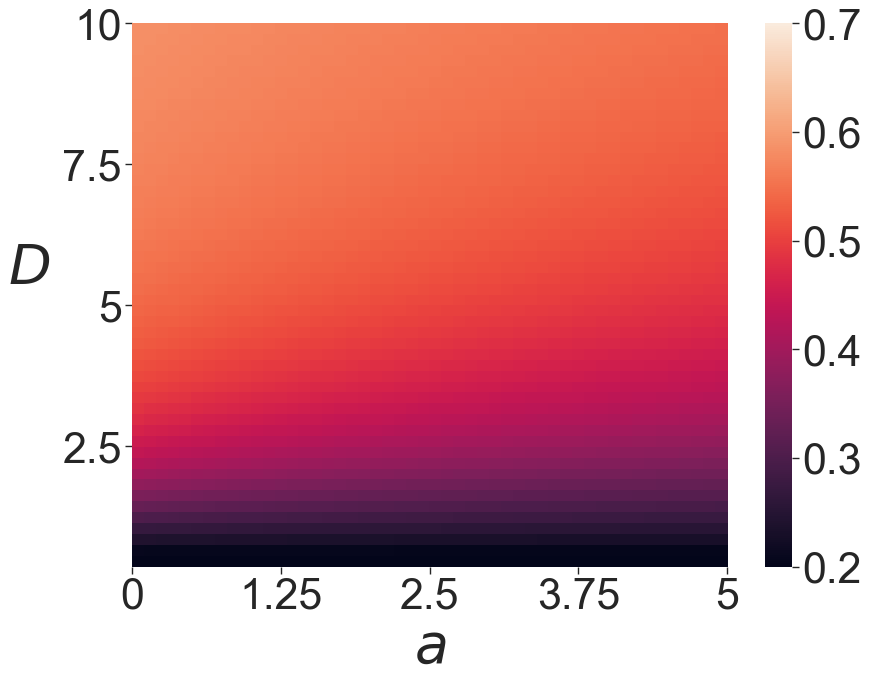

In [13]:
figure(num = None, figsize = (12, 9), dpi = 80, facecolor = 'w', edgecolor = 'k')
sns.set(font_scale = 3.5)

xticks=[-0.5, 0, 1.25, 2.5, 3.75, 5]
yticks=[2.5, 10, 7.5, 5, 2.5, 0]

ax = sns.heatmap(Heat_Matrix3, xticklabels = xticks, yticklabels = yticks, vmin = 0.2, vmax = 0.7)
ax.tick_params(left = True, bottom = True)
plt.xlabel("$a$", labelpad = 5, fontsize = 50)
plt.ylabel("$D$", labelpad = 30, fontsize = 50, rotation = 0)
plt.xticks(rotation = 0) 
plt.yticks(rotation = 0)

ax.xaxis.set_major_locator(ticker.MultipleLocator(12.49))
ax.yaxis.set_major_locator(ticker.MultipleLocator(12.97))
plt.show()

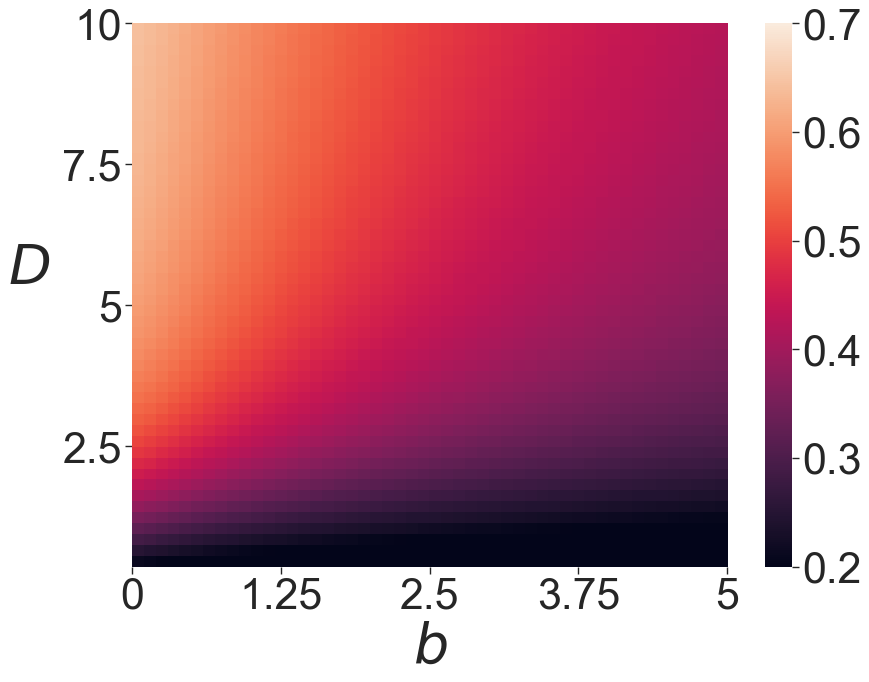

In [14]:
figure(num = None, figsize = (12, 9), dpi = 80, facecolor = 'w', edgecolor = 'k')
sns.set(font_scale = 3.5)

xticks=[-0.5, 0, 1.25, 2.5, 3.75, 5]
yticks=[2.5, 10, 7.5, 5, 2.5, 0]

ax = sns.heatmap(Heat_Matrix2, xticklabels = xticks, yticklabels = yticks, vmin = 0.2, vmax = 0.7)
ax.tick_params(left = True, bottom = True)
plt.xlabel("$b$", labelpad = 5, fontsize = 50)
plt.ylabel("$D$", labelpad = 30, fontsize = 50, rotation = 0)
plt.xticks(rotation = 0) 
plt.yticks(rotation = 0)

ax.xaxis.set_major_locator(ticker.MultipleLocator(12.49))
ax.yaxis.set_major_locator(ticker.MultipleLocator(12.97))
plt.show()